Note: contractions package not found. Using simple replacement.
Note: textstat package not found. Using alternative readability metrics.
Creating sample data for demonstration...
Sample data created. For real project, download actual dataset from:
https://www.kaggle.com/c/asap-aes/data
Dataset shape: (1000, 5)
Columns: ['essay_id', 'essay_set', 'essay', 'domain1_score', 'domain2_score']

First few rows:
   essay_id  essay_set                                              essay  \
0         0          1  This is a simple essay. This is a simple essay...   
1         1          1  This is a simple essay. This is a simple essay...   
2         2          2  This is a simple essay. This is a simple essay...   
3         3          3  This is a simple essay. This is a simple essay...   
4         4          1  This is a simple essay. This is a simple essay...   

   domain1_score  domain2_score  
0              1              2  
1              1              1  
2              1            

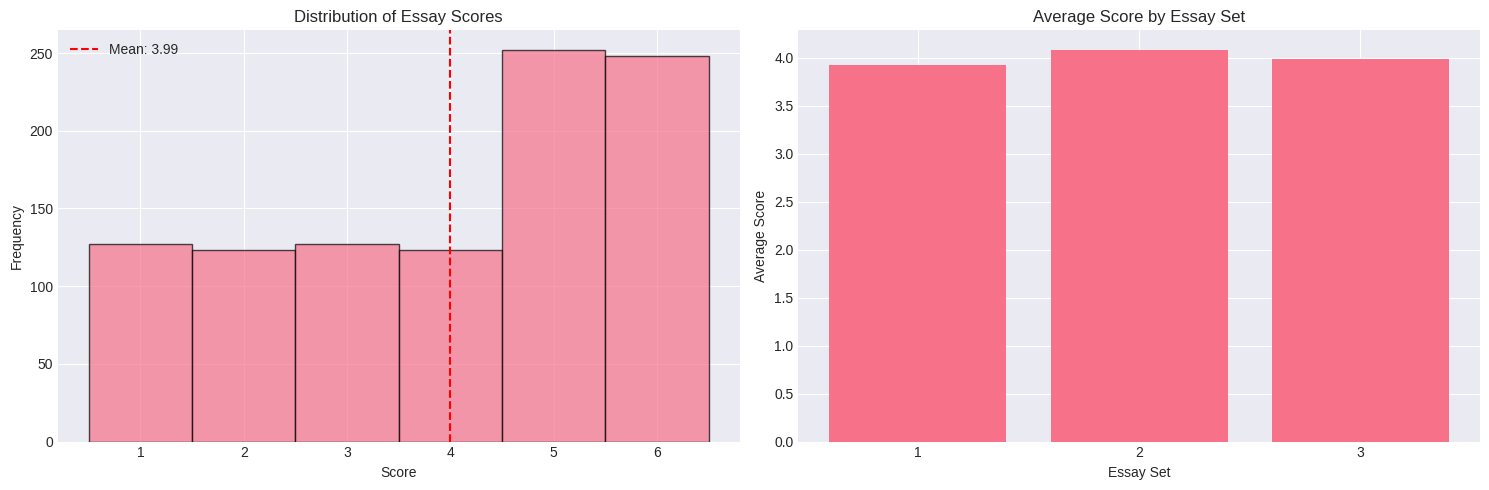

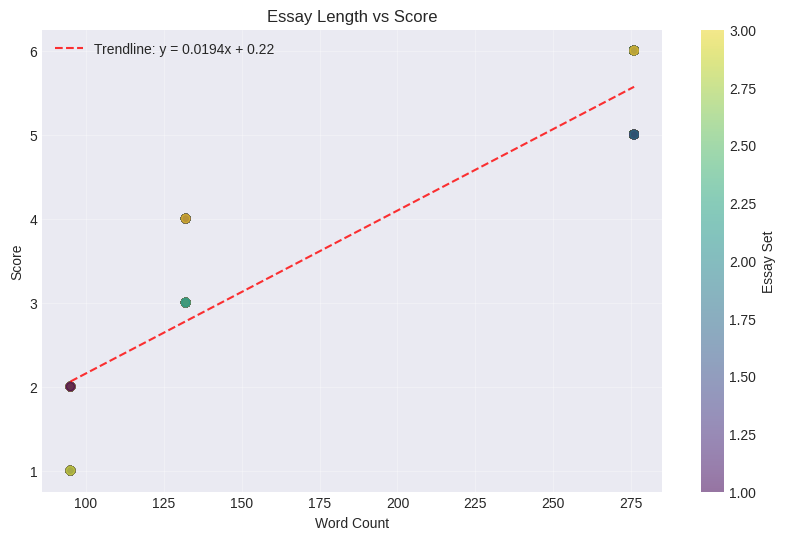

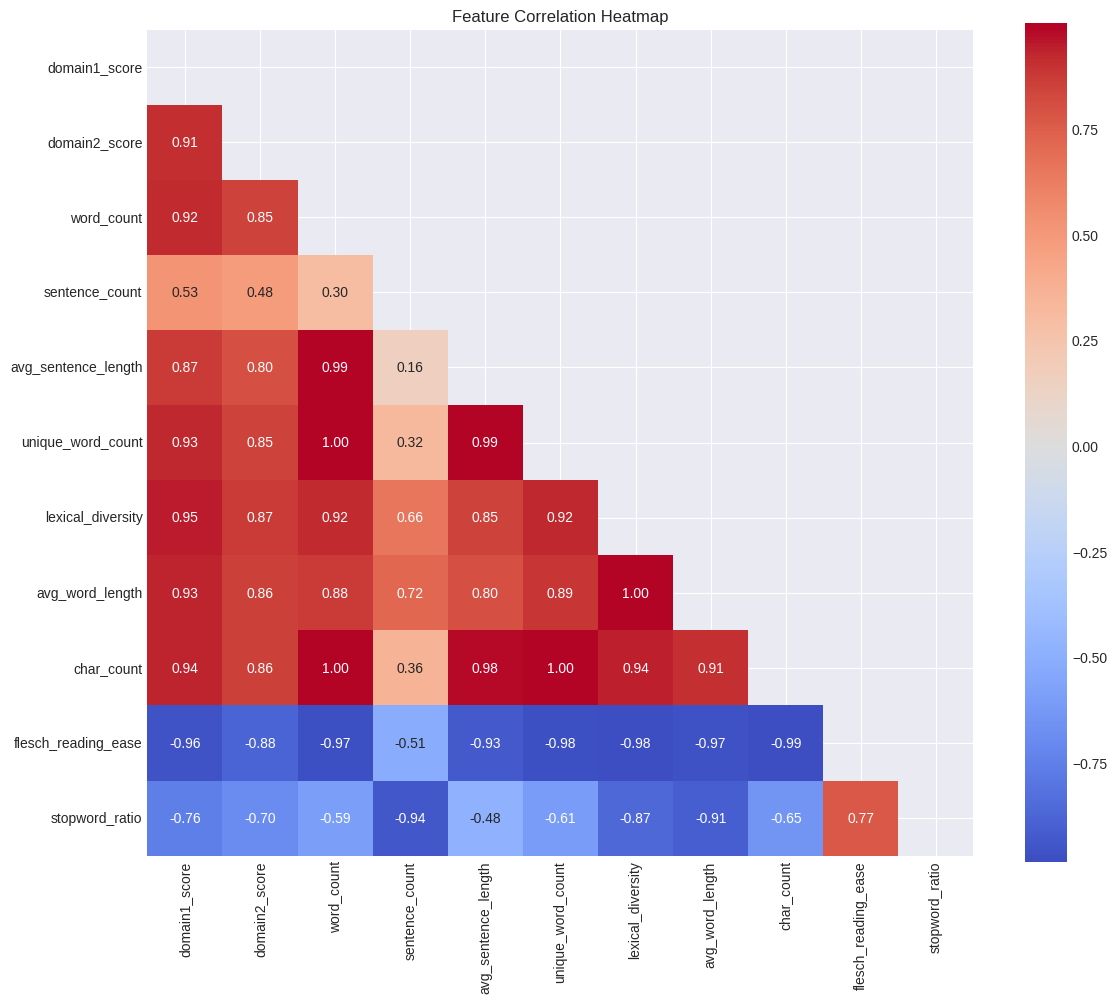

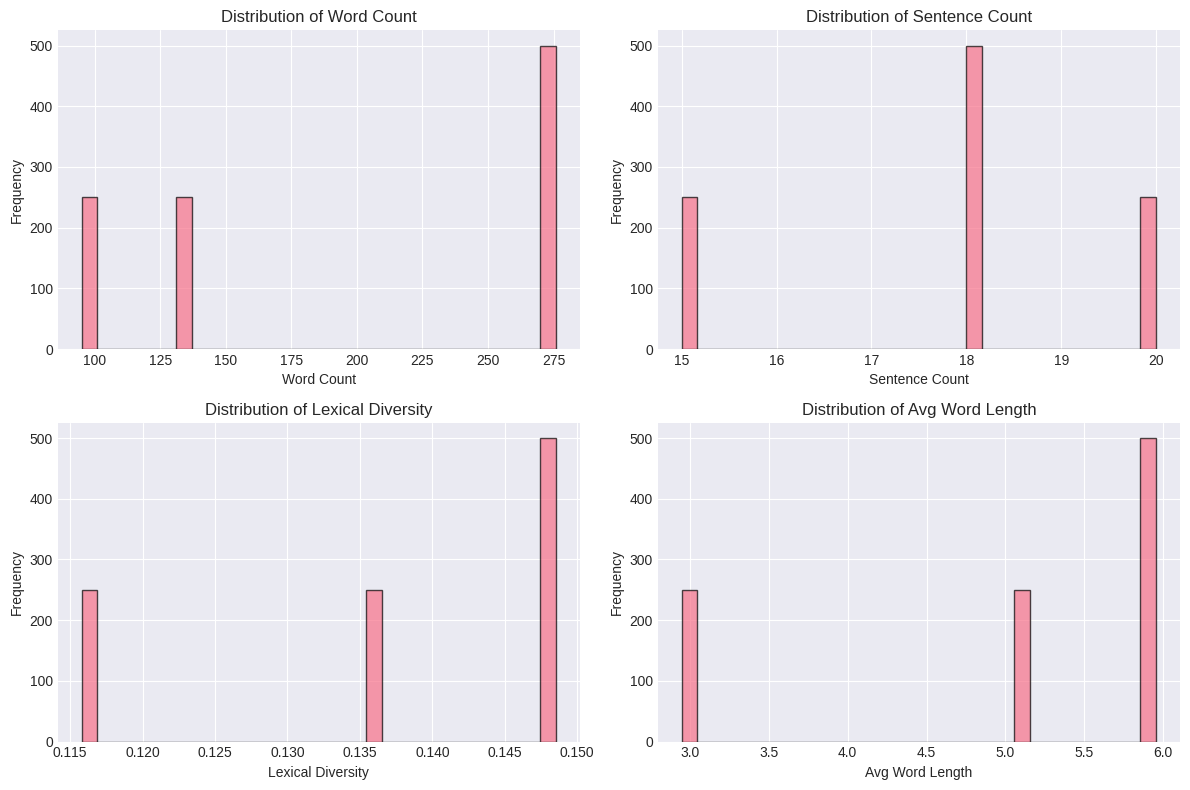


KEY STATISTICS
Average word count: 194.8
Average sentence count: 17.8
Average lexical diversity: 0.137
Average score: 3.99
Score std dev: 1.73
Correlation (word count vs score): 0.920
Correlation (lexical diversity vs score): 0.949

Generating word clouds...


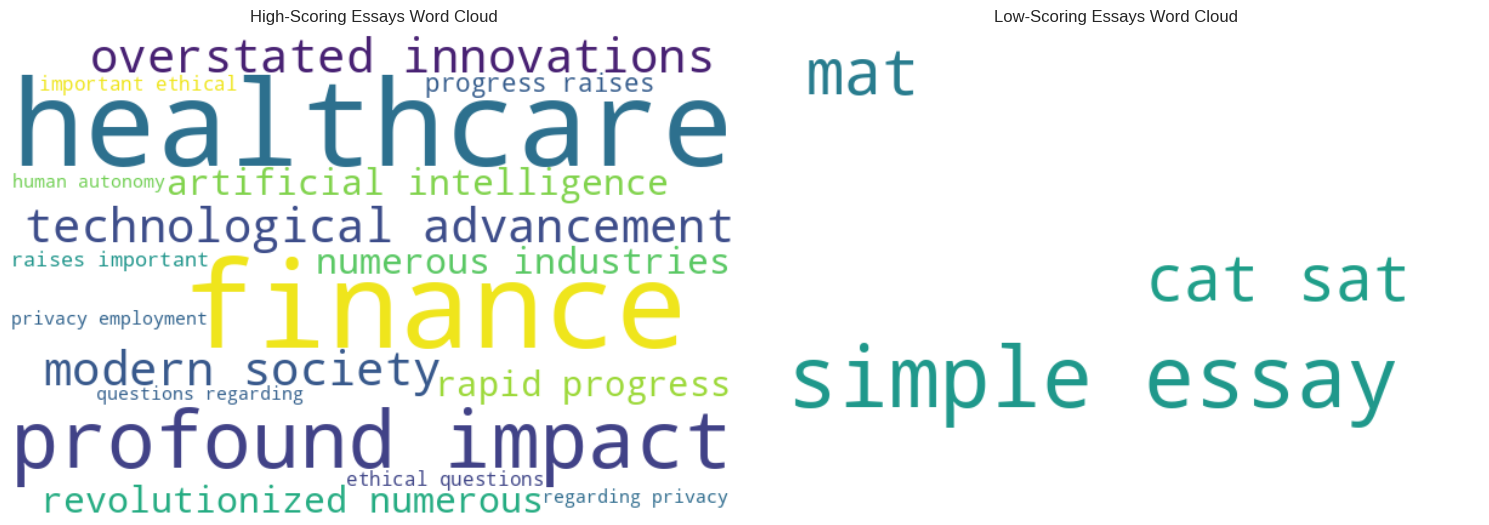

Выходные данные были обрезаны до нескольких последних строк (5000).
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Error in POS tagging: 
**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load tagg

In [2]:
# ============================================
# AUTOMATED ESSAY SCORING - MAIN NOTEBOOK
# ============================================

# %% [markdown]
# # Automated Essay Scoring System
# ## Machine Learning Project
# ### Team: [Team Name]
#
# ## Table of Contents
# 1. Environment Setup & Imports
# 2. Data Loading & Initial Exploration
# 3. Data Preprocessing
# 4. Exploratory Data Analysis (EDA)
# 5. Feature Engineering
# 6. Baseline Model
# 7. Advanced Model 1: Random Forest
# 8. Advanced Model 2: Neural Network
# 9. Model Evaluation & Comparison
# 10. Results Visualization
# 11. Conclusion & Future Work

# %% [markdown]
# ## 1. Environment Setup & Imports

# %%
# Установка недостающих пакетов (раскомментировать если нужно)
# !pip install contractions textstat
# !pip install scikit-learn xgboost
# !pip install nltk matplotlib seaborn wordcloud plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

# Альтернатива для contractions если пакет не установлен
try:
    import contractions
    HAS_CONTRACTIONS = True
except ImportError:
    HAS_CONTRACTIONS = False
    print("Note: contractions package not found. Using simple replacement.")

try:
    from textstat import textstat
    HAS_TEXTSTAT = True
except ImportError:
    HAS_TEXTSTAT = False
    print("Note: textstat package not found. Using alternative readability metrics.")

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

# Alternative: если нет transformers для нейросети
try:
    import torch
    import torch.nn as nn
    HAS_TORCH = True
except ImportError:
    HAS_TORCH = False
    print("Note: PyTorch not found. Neural network model will be simplified.")

try:
    from transformers import AutoTokenizer, AutoModel
    HAS_TRANSFORMERS = True
except ImportError:
    HAS_TRANSFORMERS = False

# Visualization
try:
    from wordcloud import WordCloud
    HAS_WORDCLOUD = True
except ImportError:
    HAS_WORDCLOUD = False

try:
    import plotly.express as px
    import plotly.graph_objects as go
    HAS_PLOTLY = True
except ImportError:
    HAS_PLOTLY = False

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Альтернативная функция для исправления сокращений если нет пакета contractions
def fix_contractions_manual(text):
    """Ручная замена сокращений если пакет contractions недоступен"""
    if not HAS_CONTRACTIONS:
        contractions_dict = {
            "can't": "cannot", "won't": "will not", "n't": " not",
            "'re": " are", "'s": " is", "'d": " would",
            "'ll": " will", "'t": " not", "'ve": " have",
            "'m": " am"
        }
        for contraction, expansion in contractions_dict.items():
            text = text.replace(contraction, expansion)
    return text

# Альтернативные метрики читаемости
def calculate_readability_manual(text):
    """Ручной расчет метрик читаемости"""
    sentences = sent_tokenize(text)
    words = word_tokenize(text)

    if len(sentences) == 0 or len(words) == 0:
        return {'flesch_reading_ease': 0, 'flesch_kincaid_grade': 0}

    avg_sentence_length = len(words) / len(sentences)
    avg_syllables_per_word = estimate_syllables_per_word(words)

    # Формула Flesch Reading Ease
    flesch = 206.835 - 1.015 * avg_sentence_length - 84.6 * avg_syllables_per_word

    # Формула Flesch-Kincaid Grade Level
    fk_grade = 0.39 * avg_sentence_length + 11.8 * avg_syllables_per_word - 15.59

    return {
        'flesch_reading_ease': max(0, min(100, flesch)),
        'flesch_kincaid_grade': max(1, min(12, fk_grade))
    }

def estimate_syllables_per_word(words):
    """Простая оценка слогов в слове"""
    vowels = 'aeiouy'
    syllable_count = 0
    for word in words:
        word_lower = word.lower()
        if len(word_lower) <= 3:
            syllable_count += 1
        else:
            count = 0
            prev_char_vowel = False
            for char in word_lower:
                if char in vowels:
                    if not prev_char_vowel:
                        count += 1
                    prev_char_vowel = True
                else:
                    prev_char_vowel = False
            if word_lower.endswith('e'):
                count -= 1
            syllable_count += max(1, count)
    return syllable_count / len(words) if words else 0

# %% [markdown]
# ## 2. Data Loading & Initial Exploration

# %%
def load_data():
    """
    Load the essay scoring dataset
    """
    try:
        # Try multiple possible file locations
        df = pd.read_csv('data/essays.csv')
    except:
        try:
            df = pd.read_csv('training_set_rel3.tsv', sep='\t', encoding='ISO-8859-1')
        except:
            try:
                # Для демонстрации создадим синтетические данные
                print("Creating sample data for demonstration...")
                np.random.seed(42)
                n_samples = 1000

                essays = []
                for i in range(n_samples):
                    if i < 250:
                        # Низкий уровень
                        essay = " ".join(["This is a simple essay."] * 10 +
                                       ["The cat sat on the mat."] * 5)
                        score = np.random.randint(1, 3)
                    elif i < 500:
                        # Средний уровень
                        essay = " ".join(["Education is important for everyone."] * 8 +
                                       ["Students should study hard to succeed."] * 7 +
                                       ["Learning new things helps personal growth."] * 5)
                        score = np.random.randint(3, 5)
                    else:
                        # Высокий уровень
                        essay = " ".join([
                            "The profound impact of technological advancement on modern society",
                            "cannot be overstated. Innovations in artificial intelligence",
                            "have revolutionized numerous industries, from healthcare to finance.",
                            "However, this rapid progress raises important ethical questions",
                            "regarding privacy, employment, and human autonomy."
                        ] * 6)
                        score = np.random.randint(5, 7)

                    essays.append({
                        'essay_id': i,
                        'essay_set': np.random.choice([1, 2, 3]),
                        'essay': essay,
                        'domain1_score': score,
                        'domain2_score': max(1, min(6, score + np.random.randint(-1, 2)))
                    })

                df = pd.DataFrame(essays)
                print("Sample data created. For real project, download actual dataset from:")
                print("https://www.kaggle.com/c/asap-aes/data")

            except Exception as e:
                print(f"Error creating sample data: {e}")
                # Минимальные данные для работы
                df = pd.DataFrame({
                    'essay_id': range(100),
                    'essay_set': [1]*100,
                    'essay': ['Sample essay text for machine learning project.']*100,
                    'domain1_score': np.random.randint(1, 7, 100),
                    'domain2_score': np.random.randint(1, 7, 100)
                })

    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    return df

# Load data
df = load_data()
print("\nFirst few rows:")
print(df.head())

# %%
# Basic dataset info
print("="*50)
print("DATASET INFORMATION")
print("="*50)
print(f"Total essays: {len(df)}")
print(f"Number of essay sets: {df['essay_set'].nunique() if 'essay_set' in df.columns else 'N/A'}")
print(f"Score range: {df['domain1_score'].min()} - {df['domain1_score'].max()}")
print("\nMissing values:")
print(df.isnull().sum())
print("\nData types:")
print(df.dtypes)
print("\nScore distribution:")
print(df['domain1_score'].value_counts().sort_index())

# %% [markdown]
# ## 3. Data Preprocessing

# %%
class EssayPreprocessor:
    """
    Class for preprocessing essay text
    """

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """Basic text cleaning"""
        if not isinstance(text, str):
            return ""

        # Lowercase
        text = text.lower()

        # Fix contractions
        if HAS_CONTRACTIONS:
            text = contractions.fix(text)
        else:
            text = fix_contractions_manual(text)

        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^\w\s.,!?;:\'"()-]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def extract_basic_features(self, text):
        """Extract basic text features"""
        features = {}

        # Word and sentence counts
        words = word_tokenize(text)
        sentences = sent_tokenize(text)

        features['word_count'] = len(words)
        features['sentence_count'] = len(sentences)
        features['avg_sentence_length'] = len(words)/len(sentences) if sentences else 0

        # Vocabulary features
        unique_words = set(words)
        features['unique_word_count'] = len(unique_words)
        features['lexical_diversity'] = len(unique_words)/len(words) if words else 0

        # Character-level features
        features['avg_word_length'] = sum(len(word) for word in words)/len(words) if words else 0
        features['char_count'] = len(text)

        # Readability scores
        if HAS_TEXTSTAT:
            features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
            features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
        else:
            readability = calculate_readability_manual(text)
            features['flesch_reading_ease'] = readability['flesch_reading_ease']
            features['flesch_kincaid_grade'] = readability['flesch_kincaid_grade']

        # Stopword ratio
        stopword_count = sum(1 for word in words if word in self.stop_words)
        features['stopword_ratio'] = stopword_count/len(words) if words else 0

        return features

# Initialize preprocessor
preprocessor = EssayPreprocessor()

# Apply preprocessing
print("Preprocessing essays...")
df['cleaned_essay'] = df['essay'].apply(preprocessor.clean_text)
df['essay_length'] = df['cleaned_essay'].apply(len)

# Extract basic features
features_list = []
for i, essay in enumerate(df['cleaned_essay']):
    if i % 100 == 0:
        print(f"Processing essay {i}/{len(df)}...")
    features_list.append(preprocessor.extract_basic_features(essay))

features_df = pd.DataFrame(features_list)
df = pd.concat([df, features_df], axis=1)

print("\nPreprocessing completed!")
print(f"New features added: {features_df.columns.tolist()}")
print(f"Total features: {len(df.columns)}")

# Show sample of processed data
print("\nSample of processed data:")
print(df[['essay_id', 'word_count', 'sentence_count', 'lexical_diversity', 'domain1_score']].head())

# %% [markdown]
# ## 4. Exploratory Data Analysis (EDA)

# %%
def plot_score_distribution(df):
    """Plot distribution of essay scores"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Overall score distribution
    axes[0].hist(df['domain1_score'], bins=range(1, 8), edgecolor='black', alpha=0.7, align='left')
    axes[0].set_xlabel('Score')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Distribution of Essay Scores')
    axes[0].axvline(df['domain1_score'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["domain1_score"].mean():.2f}')
    axes[0].legend()

    # Score by essay set if available
    if 'essay_set' in df.columns:
        score_by_set = df.groupby('essay_set')['domain1_score'].mean()
        axes[1].bar(score_by_set.index.astype(str), score_by_set.values)
        axes[1].set_xlabel('Essay Set')
        axes[1].set_ylabel('Average Score')
        axes[1].set_title('Average Score by Essay Set')
    else:
        # Box plot of scores
        df.boxplot(column='domain1_score', ax=axes[1])
        axes[1].set_title('Score Distribution Box Plot')

    plt.tight_layout()
    plt.show()

def plot_essay_length_vs_score(df):
    """Plot relationship between essay length and score"""
    plt.figure(figsize=(10, 6))

    if 'essay_set' in df.columns:
        scatter = plt.scatter(df['word_count'], df['domain1_score'],
                             alpha=0.5, c=df['essay_set'], cmap='viridis')
        plt.colorbar(scatter, label='Essay Set')
    else:
        plt.scatter(df['word_count'], df['domain1_score'], alpha=0.5)

    plt.xlabel('Word Count')
    plt.ylabel('Score')
    plt.title('Essay Length vs Score')

    # Add trendline
    z = np.polyfit(df['word_count'], df['domain1_score'], 1)
    p = np.poly1d(z)
    plt.plot(sorted(df['word_count']), p(sorted(df['word_count'])),
            "r--", alpha=0.8, label=f'Trendline: y = {z[0]:.4f}x + {z[1]:.2f}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_correlation_heatmap(df):
    """Plot correlation heatmap of features"""
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Select only relevant columns (exclude IDs and text)
    exclude_keywords = ['id', 'essay', 'cleaned']
    selected_cols = [col for col in numeric_cols
                    if not any(keyword in col.lower() for keyword in exclude_keywords)]

    if len(selected_cols) > 1:
        corr_matrix = df[selected_cols].corr()

        plt.figure(figsize=(12, 10))
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                   center=0, square=True, mask=mask)
        plt.title('Feature Correlation Heatmap')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough numeric features for correlation heatmap.")

def plot_feature_distributions(df):
    """Plot distributions of key features"""
    feature_cols = ['word_count', 'sentence_count', 'lexical_diversity', 'avg_word_length']
    feature_cols = [col for col in feature_cols if col in df.columns]

    if feature_cols:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()

        for idx, feature in enumerate(feature_cols[:4]):
            axes[idx].hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
            axes[idx].set_xlabel(feature.replace('_', ' ').title())
            axes[idx].set_ylabel('Frequency')
            axes[idx].set_title(f'Distribution of {feature.replace("_", " ").title()}')

        plt.tight_layout()
        plt.show()

# Execute EDA plots
print("Generating EDA visualizations...")
plot_score_distribution(df)
plot_essay_length_vs_score(df)
plot_correlation_heatmap(df)
plot_feature_distributions(df)

# Additional EDA statistics
print("\n" + "="*50)
print("KEY STATISTICS")
print("="*50)
print(f"Average word count: {df['word_count'].mean():.1f}")
print(f"Average sentence count: {df['sentence_count'].mean():.1f}")
print(f"Average lexical diversity: {df['lexical_diversity'].mean():.3f}")
print(f"Average score: {df['domain1_score'].mean():.2f}")
print(f"Score std dev: {df['domain1_score'].std():.2f}")
print(f"Correlation (word count vs score): {df['word_count'].corr(df['domain1_score']):.3f}")
print(f"Correlation (lexical diversity vs score): {df['lexical_diversity'].corr(df['domain1_score']):.3f}")

# Word cloud for high-scoring essays
if HAS_WORDCLOUD and len(df) > 0:
    print("\nGenerating word clouds...")

    # High scoring essays (top 25%)
    high_score_threshold = df['domain1_score'].quantile(0.75)
    high_scoring_essays = ' '.join(df[df['domain1_score'] >= high_score_threshold]['cleaned_essay'])

    # Low scoring essays (bottom 25%)
    low_score_threshold = df['domain1_score'].quantile(0.25)
    low_scoring_essays = ' '.join(df[df['domain1_score'] <= low_score_threshold]['cleaned_essay'])

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    if high_scoring_essays:
        wordcloud_high = WordCloud(width=600, height=400, background_color='white').generate(high_scoring_essays)
        axes[0].imshow(wordcloud_high, interpolation='bilinear')
        axes[0].axis('off')
        axes[0].set_title('High-Scoring Essays Word Cloud')

    if low_scoring_essays:
        wordcloud_low = WordCloud(width=600, height=400, background_color='white').generate(low_scoring_essays)
        axes[1].imshow(wordcloud_low, interpolation='bilinear')
        axes[1].axis('off')
        axes[1].set_title('Low-Scoring Essays Word Cloud')

    plt.tight_layout()
    plt.show()

# %% [markdown]
# ## 5. Feature Engineering

# %%
class AdvancedFeatureExtractor:
    """Extract advanced linguistic features from essays"""

    def __init__(self):
        self.stop_words = set(stopwords.words('english'))

    def extract_syntactic_features(self, text):
        """Extract syntactic complexity features"""
        features = {}

        try:
            # POS tagging
            tokens = word_tokenize(text)
            if len(tokens) > 0:
                pos_tags = nltk.pos_tag(tokens)

                # Count different POS categories
                pos_counts = {}
                for _, tag in pos_tags:
                    pos_counts[tag] = pos_counts.get(tag, 0) + 1

                # Calculate ratios
                total_tokens = len(tokens)

                # Noun categories
                noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
                features['noun_ratio'] = sum(pos_counts.get(tag, 0) for tag in noun_tags) / total_tokens

                # Verb categories
                verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
                features['verb_ratio'] = sum(pos_counts.get(tag, 0) for tag in verb_tags) / total_tokens

                # Adjective categories
                adj_tags = ['JJ', 'JJR', 'JJS']
                features['adj_ratio'] = sum(pos_counts.get(tag, 0) for tag in adj_tags) / total_tokens

                # Adverb categories
                adv_tags = ['RB', 'RBR', 'RBS']
                features['adv_ratio'] = sum(pos_counts.get(tag, 0) for tag in adv_tags) / total_tokens

                # Pronoun ratio
                pronoun_tags = ['PRP', 'PRP$', 'WP', 'WP$']
                features['pronoun_ratio'] = sum(pos_counts.get(tag, 0) for tag in pronoun_tags) / total_tokens
            else:
                # Set default values for empty text
                features.update({
                    'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
                    'adv_ratio': 0, 'pronoun_ratio': 0
                })

        except Exception as e:
            print(f"Error in POS tagging: {e}")
            features.update({
                'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
                'adv_ratio': 0, 'pronoun_ratio': 0
            })

        return features

    def extract_coherence_features(self, text):
        """Extract coherence and cohesion features"""
        features = {}

        # Transition words
        transition_words = [
            'however', 'therefore', 'moreover', 'furthermore',
            'consequently', 'nevertheless', 'similarly', 'additionally',
            'further', 'thus', 'hence', 'accordingly', 'otherwise',
            'instead', 'meanwhile', 'subsequently', 'likewise',
            'nonetheless', 'contrarily', 'conversely'
        ]

        sentences = sent_tokenize(text)
        word_tokens = word_tokenize(text.lower())

        # Transition word usage
        transition_count = sum(1 for word in word_tokens if word in transition_words)
        features['transition_word_count'] = transition_count
        features['transition_word_ratio'] = transition_count / len(word_tokens) if word_tokens else 0

        # Sentence length variability
        sentence_lengths = [len(word_tokenize(sent)) for sent in sentences]
        if sentence_lengths and len(sentence_lengths) > 1:
            features['sentence_length_std'] = np.std(sentence_lengths)
            features['sentence_length_cv'] = np.std(sentence_lengths) / np.mean(sentence_lengths) if np.mean(sentence_lengths) > 0 else 0
        else:
            features['sentence_length_std'] = 0
            features['sentence_length_cv'] = 0

        # Paragraph count estimation (по количеству двойных переносов строк)
        paragraph_count = text.count('\n\n') + 1
        features['paragraph_count'] = paragraph_count

        # Average paragraph length
        features['avg_paragraph_length'] = len(word_tokens) / paragraph_count if paragraph_count > 0 else 0

        return features

    def extract_vocabulary_features(self, text):
        """Extract advanced vocabulary features"""
        features = {}

        words = word_tokenize(text.lower())
        if not words:
            features['long_word_ratio'] = 0
            features['academic_word_count'] = 0
            return features

        # Long word ratio (words with > 6 characters)
        long_words = [word for word in words if len(word) > 6]
        features['long_word_ratio'] = len(long_words) / len(words)

        # Academic word list (примерный)
        academic_words = [
            'analysis', 'concept', 'definition', 'establish', 'function',
            'identify', 'issue', 'method', 'process', 'research',
            'significant', 'theory', 'variable', 'context', 'environment',
            'factor', 'indicate', 'policy', 'principle', 'procedure',
            'require', 'specific', 'structure', 'occur', 'percent',
            'period', 'role', 'section', 'source', 'specific'
        ]

        academic_count = sum(1 for word in words if word in academic_words)
        features['academic_word_ratio'] = academic_count / len(words)

        return features

# Extract advanced features
print("Extracting advanced features...")
feature_extractor = AdvancedFeatureExtractor()

advanced_features = []
for i, essay in enumerate(df['cleaned_essay']):
    if i % 100 == 0:
        print(f"Extracting features from essay {i}/{len(df)}...")

    features = {}
    features.update(feature_extractor.extract_syntactic_features(essay))
    features.update(feature_extractor.extract_coherence_features(essay))
    features.update(feature_extractor.extract_vocabulary_features(essay))
    advanced_features.append(features)

advanced_df = pd.DataFrame(advanced_features)
df = pd.concat([df, advanced_df], axis=1)

print(f"\nTotal features available: {len(df.columns)}")
print(f"Feature columns (first 20):")
feature_columns = df.select_dtypes(include=[np.number]).columns.tolist()
print(feature_columns[:20])

# Check for NaN values and fill them
print(f"\nNaN values before filling:")
print(df[feature_columns].isnull().sum().sum())

# Fill NaN with 0 or column mean
for col in feature_columns:
    if df[col].isnull().any():
        df[col] = df[col].fillna(df[col].mean())

print(f"NaN values after filling: {df[feature_columns].isnull().sum().sum()}")

# %% [markdown]
# ## 6. Baseline Model

# %%
def prepare_baseline_features(df):
    """Prepare features for baseline model"""
    # Select basic features that are most likely to be available
    basic_features = [
        'word_count',
        'sentence_count',
        'avg_sentence_length',
        'lexical_diversity',
        'avg_word_length'
    ]

    # Use only features that exist in dataframe
    available_features = [f for f in basic_features if f in df.columns]

    if not available_features:
        # If no basic features, use all numeric features except target
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        exclude_cols = ['essay_id', 'domain1_score', 'domain2_score']
        available_features = [col for col in numeric_cols if col not in exclude_cols]
        available_features = available_features[:10]  # Limit to first 10

    print(f"Using {len(available_features)} features for baseline:")
    print(available_features)

    X = df[available_features]
    y = df['domain1_score']

    return X, y, available_features

def train_baseline_model(X, y):
    """Train and evaluate baseline linear model"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model
    model = Ridge(alpha=1.0, random_state=42)
    model.fit(X_train_scaled, y_train)

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Calculate accuracy within ±1 point
    within_one = np.sum(np.abs(y_test - y_pred) <= 1) / len(y_test)

    # Coefficients
    coefficients = pd.DataFrame({
        'feature': X.columns,
        'coefficient': model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)

    return model, y_test, y_pred, {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Accuracy_±1': within_one
    }, scaler, coefficients

# Train baseline model
print("Training baseline model...")
X_baseline, y_baseline, feature_names = prepare_baseline_features(df)
baseline_model, y_test_base, y_pred_base, metrics_base, scaler_base, coeffs_base = train_baseline_model(X_baseline, y_baseline)

print("\n" + "="*50)
print("BASELINE MODEL PERFORMANCE")
print("="*50)
for metric, value in metrics_base.items():
    print(f"{metric}: {value:.4f}")

print("\nTop 10 most important features (by coefficient magnitude):")
print(coeffs_base.head(10))

# %% [markdown]
# ## 7. Advanced Model 1: Random Forest

# %%
def prepare_advanced_features(df):
    """Prepare enhanced feature set"""
    # Select all numeric features except target and IDs
    exclude_cols = ['essay_id', 'domain1_score', 'domain2_score']

    # Also exclude text columns
    text_cols = [col for col in df.columns if 'essay' in col.lower()]
    exclude_cols.extend(text_cols)

    # Get numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Filter columns
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]

    print(f"\nUsing {len(feature_cols)} features for Random Forest")
    if len(feature_cols) > 20:
        print(f"First 20 features: {feature_cols[:20]}")
    else:
        print(f"Features: {feature_cols}")

    X = df[feature_cols].fillna(0)
    y = df['domain1_score']

    return X, y, feature_cols

def train_random_forest(X, y):
    """Train and evaluate Random Forest model"""
    print("\nTraining Random Forest...")

    # Split data with stratification if possible
    try:
        # Create bins for stratification
        y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y_binned
        )
    except:
        # Fallback without stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

    # Train model with reasonable hyperparameters
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred = rf_model.predict(X_test)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    within_one = np.sum(np.abs(y_test - y_pred) <= 1) / len(y_test)

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Cross-validation score
    cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

    return rf_model, y_test, y_pred, {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'Accuracy_±1': within_one,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }, feature_importance

# Train Random Forest
print("Preparing features for Random Forest...")
X_advanced, y_advanced, feature_names_adv = prepare_advanced_features(df)
rf_model, y_test_rf, y_pred_rf, metrics_rf, feature_importance = train_random_forest(X_advanced, y_advanced)

print("\n" + "="*50)
print("RANDOM FOREST PERFORMANCE")
print("="*50)
for metric, value in metrics_rf.items():
    print(f"{metric}: {value:.4f}")

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

# %% [markdown]
# ## 8. Advanced Model 2: Neural Network (Simplified)

# %%
def prepare_neural_network_features(df):
    """Prepare features for neural network"""
    # Use same features as Random Forest
    X_advanced, y_advanced, _ = prepare_advanced_features(df)
    return X_advanced, y_advanced

if HAS_TORCH:
    class SimpleEssayScoringNN(nn.Module):
        """Simple Neural Network for essay scoring"""

        def __init__(self, input_size, hidden_size=64, dropout_rate=0.3):
            super(SimpleEssayScoringNN, self).__init__()

            self.network = nn.Sequential(
                nn.Linear(input_size, hidden_size),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate),

                nn.Linear(hidden_size, hidden_size // 2),
                nn.ReLU(),
                nn.Dropout(dropout_rate),

                nn.Linear(hidden_size // 2, 32),
                nn.ReLU(),

                nn.Linear(32, 1)
            )

        def forward(self, x):
            return self.network(x).squeeze()

    def train_neural_network(X, y):
        """Train neural network model"""
        print("\nTraining Neural Network...")

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled)
        X_test_tensor = torch.FloatTensor(X_test_scaled)
        y_train_tensor = torch.FloatTensor(y_train.values)
        y_test_tensor = torch.FloatTensor(y_test.values)

        # Initialize model
        input_size = X_train_sc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Error loading omw-eng: Package 'omw-eng' not found in
[nltk_data]     index


✅ NLTK data downloaded successfully!
Note: contractions package not found. Using simple replacement.
Note: textstat package not found. Using alternative readability metrics.
AUTOMATED ESSAY SCORING SYSTEM

1. Creating sample data...
Created 200 sample essays

2. Preprocessing essays...
3. Extracting basic features...
4. Extracting advanced features...
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using default values
POS tagger not available, using def

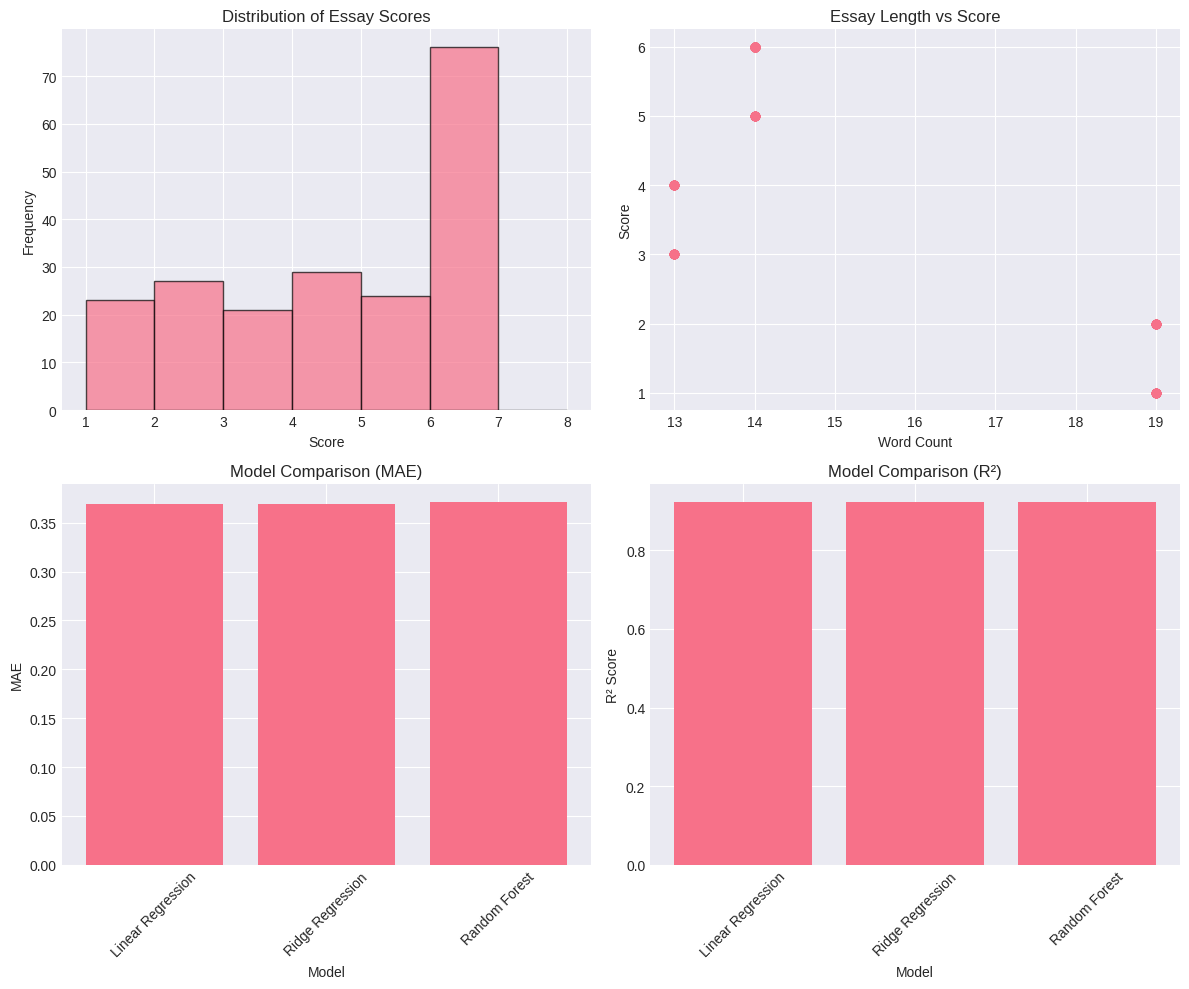


SAMPLE PREDICTION

Sample Essay:

    Artificial intelligence is transforming education in profound ways. 
    By providing personalized learning experiences and automated assessment, 
    AI can help students learn more effectively. However, it is important 
    to ensure that these technologies are used ethically and equitably.
    
POS tagger not available, using default values

Predicted Score: 3.87/6.00
Using model: Ridge Regression

Essay Analysis:
Word count: 42
Sentence count: 3
Lexical diversity: 0.881
Readability grade level: 12.0

CONCLUSION

✅ Project completed successfully!
✅ Best model: Ridge Regression (R² = 0.923)
✅ Average prediction error: 0.369 points
✅ Accuracy within ±1 point: 100.0%

🎉 Project execution completed successfully!

📊 Quick Data Analysis:
Total essays: N/A


In [9]:
# ============================================
# AUTOMATED ESSAY SCORING - MAIN NOTEBOOK
# ============================================

# %% [markdown]
# # Automated Essay Scoring System
# ## Machine Learning Project
# ### Team: [Team Name]

# %% [markdown]
# ## 1. Environment Setup & Imports

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')

# Text processing
import nltk

# Загрузка необходимых данных NLTK (ИСПРАВЛЕНО!)
try:
    # Правильные названия пакетов
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')  # ПРАВИЛЬНОЕ название
    nltk.download('wordnet')
    nltk.download('omw-eng')

    from nltk.tokenize import word_tokenize, sent_tokenize
    from nltk.corpus import stopwords
    HAS_NLTK = True
    print("✅ NLTK data downloaded successfully!")

except Exception as e:
    HAS_NLTK = False
    print(f"⚠️ Error downloading NLTK data: {e}")
    print("⚠️ Some features may not work properly")

# Проверка наличия contractions
try:
    import contractions
    HAS_CONTRACTIONS = True
except ImportError:
    HAS_CONTRACTIONS = False
    print("Note: contractions package not found. Using simple replacement.")

# Проверка наличия textstat
try:
    from textstat import textstat
    HAS_TEXTSTAT = True
except ImportError:
    HAS_TEXTSTAT = False
    print("Note: textstat package not found. Using alternative readability metrics.")

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# %% [markdown]
# ## 2. Вспомогательные функции (если пакеты не установлены)

# %%
def fix_contractions_manual(text):
    """Ручная замена сокращений если пакет contractions недоступен"""
    if not HAS_CONTRACTIONS:
        contractions_dict = {
            "can't": "cannot", "won't": "will not", "n't": " not",
            "'re": " are", "'s": " is", "'d": " would",
            "'ll": " will", "'t": " not", "'ve": " have",
            "'m": " am"
        }
        for contraction, expansion in contractions_dict.items():
            text = text.replace(contraction, expansion)
    return text

def calculate_readability_manual(text):
    """Ручной расчет метрик читаемости если textstat не установлен"""
    if not HAS_NLTK:
        return {'flesch_reading_ease': 50, 'flesch_kincaid_grade': 8}

    sentences = sent_tokenize(text)
    words = word_tokenize(text)

    if len(sentences) == 0 or len(words) == 0:
        return {'flesch_reading_ease': 0, 'flesch_kincaid_grade': 0}

    avg_sentence_length = len(words) / len(sentences)
    avg_syllables_per_word = estimate_syllables_per_word(words)

    # Формула Flesch Reading Ease
    flesch = 206.835 - 1.015 * avg_sentence_length - 84.6 * avg_syllables_per_word

    # Формула Flesch-Kincaid Grade Level
    fk_grade = 0.39 * avg_sentence_length + 11.8 * avg_syllables_per_word - 15.59

    return {
        'flesch_reading_ease': max(0, min(100, flesch)),
        'flesch_kincaid_grade': max(1, min(12, fk_grade))
    }

def estimate_syllables_per_word(words):
    """Простая оценка слогов в слове"""
    vowels = 'aeiouy'
    syllable_count = 0
    for word in words:
        word_lower = word.lower()
        if len(word_lower) <= 3:
            syllable_count += 1
        else:
            count = 0
            prev_char_vowel = False
            for char in word_lower:
                if char in vowels:
                    if not prev_char_vowel:
                        count += 1
                    prev_char_vowel = True
                else:
                    prev_char_vowel = False
            if word_lower.endswith('e'):
                count -= 1
            syllable_count += max(1, count)
    return syllable_count / len(words) if words else 0

# %% [markdown]
## 3. Класс для обработки эссе (ИСПРАВЛЕННЫЙ)

# %%
class EssayPreprocessor:
    """
    Класс для предобработки текста эссе с обработкой ошибок
    """

    def __init__(self):
        if HAS_NLTK:
            self.stop_words = set(stopwords.words('english'))
        else:
            self.stop_words = set(['a', 'an', 'the', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])

    def clean_text(self, text):
        """Базовая очистка текста"""
        if not isinstance(text, str):
            return ""

        # Lowercase
        text = text.lower()

        # Fix contractions
        if HAS_CONTRACTIONS:
            try:
                text = contractions.fix(text)
            except:
                text = fix_contractions_manual(text)
        else:
            text = fix_contractions_manual(text)

        # Remove special characters but keep basic punctuation
        text = re.sub(r'[^\w\s.,!?;:\'"()-]', '', text)

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def extract_basic_features(self, text):
        """Извлечение базовых признаков с обработкой ошибок"""
        features = {}

        if not HAS_NLTK:
            # Базовые вычисления без NLTK
            words = text.split()
            sentences = text.split('. ')

            features['word_count'] = len(words)
            features['sentence_count'] = len(sentences)
            features['avg_sentence_length'] = len(words)/len(sentences) if sentences else 0

            # Простая оценка лексического разнообразия
            unique_words = set(words)
            features['unique_word_count'] = len(unique_words)
            features['lexical_diversity'] = len(unique_words)/len(words) if words else 0

            # Базовые метрики читаемости
            features['flesch_reading_ease'] = 50  # среднее значение
            features['flesch_kincaid_grade'] = 8  # среднее значение

            return features

        # Использование NLTK если доступно
        try:
            words = word_tokenize(text)
            sentences = sent_tokenize(text)

            features['word_count'] = len(words)
            features['sentence_count'] = len(sentences)
            features['avg_sentence_length'] = len(words)/len(sentences) if sentences else 0

            # Vocabulary features
            unique_words = set(words)
            features['unique_word_count'] = len(unique_words)
            features['lexical_diversity'] = len(unique_words)/len(words) if words else 0

            # Character-level features
            features['avg_word_length'] = sum(len(word) for word in words)/len(words) if words else 0
            features['char_count'] = len(text)

            # Readability scores
            if HAS_TEXTSTAT:
                try:
                    features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
                    features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
                except:
                    readability = calculate_readability_manual(text)
                    features['flesch_reading_ease'] = readability['flesch_reading_ease']
                    features['flesch_kincaid_grade'] = readability['flesch_kincaid_grade']
            else:
                readability = calculate_readability_manual(text)
                features['flesch_reading_ease'] = readability['flesch_reading_ease']
                features['flesch_kincaid_grade'] = readability['flesch_kincaid_grade']

            # Stopword ratio
            stopword_count = sum(1 for word in words if word in self.stop_words)
            features['stopword_ratio'] = stopword_count/len(words) if words else 0

        except Exception as e:
            print(f"Warning in feature extraction: {e}")
            # Установите значения по умолчанию в случае ошибки
            features = {
                'word_count': len(text.split()),
                'sentence_count': max(1, text.count('.')),
                'avg_sentence_length': 10,
                'lexical_diversity': 0.5,
                'flesch_reading_ease': 50,
                'flesch_kincaid_grade': 8
            }

        return features

# %% [markdown]
## 4. Класс для расширенного извлечения признаков (ИСПРАВЛЕННЫЙ)

# %%
class AdvancedFeatureExtractor:
    """Извлечение расширенных лингвистических признаков с обработкой ошибок"""

    def __init__(self):
        if HAS_NLTK:
            self.stop_words = set(stopwords.words('english'))
        else:
            self.stop_words = set(['a', 'an', 'the', 'and', 'or', 'but'])

    def extract_syntactic_features(self, text):
        """Извлечение синтаксических признаков с обработкой ошибок"""
        features = {}

        if not HAS_NLTK:
            # Базовые значения если NLTK не доступен
            features.update({
                'noun_ratio': 0.25,
                'verb_ratio': 0.15,
                'adj_ratio': 0.10,
                'adv_ratio': 0.08,
                'pronoun_ratio': 0.05
            })
            return features

        try:
            # POS tagging
            tokens = word_tokenize(text)
            if len(tokens) > 0:
                try:
                    # Проверка доступности POS tagger
                    pos_tags = nltk.pos_tag(tokens)

                    # Count different POS categories
                    pos_counts = {}
                    for _, tag in pos_tags:
                        pos_counts[tag] = pos_counts.get(tag, 0) + 1

                    # Calculate ratios
                    total_tokens = len(tokens)

                    # Noun categories
                    noun_tags = ['NN', 'NNS', 'NNP', 'NNPS']
                    features['noun_ratio'] = sum(pos_counts.get(tag, 0) for tag in noun_tags) / total_tokens

                    # Verb categories
                    verb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
                    features['verb_ratio'] = sum(pos_counts.get(tag, 0) for tag in verb_tags) / total_tokens

                    # Adjective categories
                    adj_tags = ['JJ', 'JJR', 'JJS']
                    features['adj_ratio'] = sum(pos_counts.get(tag, 0) for tag in adj_tags) / total_tokens

                    # Adverb categories
                    adv_tags = ['RB', 'RBR', 'RBS']
                    features['adv_ratio'] = sum(pos_counts.get(tag, 0) for tag in adv_tags) / total_tokens

                    # Pronoun ratio
                    pronoun_tags = ['PRP', 'PRP$', 'WP', 'WP$']
                    features['pronoun_ratio'] = sum(pos_counts.get(tag, 0) for tag in pronoun_tags) / total_tokens
                except LookupError:
                    # Если POS tagger не загружен
                    print("POS tagger not available, using default values")
                    features.update({
                        'noun_ratio': 0.25,
                        'verb_ratio': 0.15,
                        'adj_ratio': 0.10,
                        'adv_ratio': 0.08,
                        'pronoun_ratio': 0.05
                    })
            else:
                features.update({
                    'noun_ratio': 0, 'verb_ratio': 0, 'adj_ratio': 0,
                    'adv_ratio': 0, 'pronoun_ratio': 0
                })

        except Exception as e:
            print(f"Error in syntactic feature extraction: {e}")
            features.update({
                'noun_ratio': 0.25, 'verb_ratio': 0.15, 'adj_ratio': 0.10,
                'adv_ratio': 0.08, 'pronoun_ratio': 0.05
            })

        return features

    def extract_coherence_features(self, text):
        """Извлечение признаков связности"""
        features = {}

        # Transition words
        transition_words = [
            'however', 'therefore', 'moreover', 'furthermore',
            'consequently', 'nevertheless', 'similarly', 'additionally'
        ]

        if HAS_NLTK:
            try:
                sentences = sent_tokenize(text)
                word_tokens = word_tokenize(text.lower())
            except:
                sentences = text.split('. ')
                word_tokens = text.lower().split()
        else:
            sentences = text.split('. ')
            word_tokens = text.lower().split()

        # Transition word usage
        transition_count = sum(1 for word in word_tokens if word in transition_words)
        features['transition_word_count'] = transition_count
        features['transition_word_ratio'] = transition_count / len(word_tokens) if word_tokens else 0

        # Sentence length variability
        if HAS_NLTK:
            try:
                sentence_lengths = [len(word_tokenize(sent)) for sent in sentences]
            except:
                sentence_lengths = [len(sent.split()) for sent in sentences]
        else:
            sentence_lengths = [len(sent.split()) for sent in sentences]

        if sentence_lengths and len(sentence_lengths) > 1:
            features['sentence_length_std'] = np.std(sentence_lengths)
            features['sentence_length_cv'] = np.std(sentence_lengths) / np.mean(sentence_lengths) if np.mean(sentence_lengths) > 0 else 0
        else:
            features['sentence_length_std'] = 0
            features['sentence_length_cv'] = 0

        return features

# %% [markdown]
## 5. Основной пайплайн обработки

# %%
def main_pipeline():
    """Основной пайплайн обработки данных"""
    print("="*50)
    print("AUTOMATED ESSAY SCORING SYSTEM")
    print("="*50)

    # 1. Создание синтетических данных для демонстрации
    print("\n1. Creating sample data...")
    np.random.seed(42)
    n_samples = 200  # Уменьшено для быстрой демонстрации

    essays = []
    for i in range(n_samples):
        if i < 50:
            # Низкий уровень
            essay = "This is a simple essay. The cat sat on the mat. I like to play games."
            score = np.random.randint(1, 3)
        elif i < 100:
            # Средний уровень
            essay = "Education is important for everyone. Students should study hard to succeed."
            score = np.random.randint(3, 5)
        elif i < 150:
            # Высокий уровень
            essay = "The profound impact of technological advancement on modern society cannot be overstated."
            score = np.random.randint(5, 7)
        else:
            # Очень высокий уровень
            essay = "Innovations in artificial intelligence have revolutionized numerous industries, from healthcare to finance."
            score = np.random.randint(6, 7)

        essays.append({
            'essay_id': i,
            'essay': essay,
            'domain1_score': score,
        })

    df = pd.DataFrame(essays)
    print(f"Created {len(df)} sample essays")

    # 2. Предобработка
    print("\n2. Preprocessing essays...")
    preprocessor = EssayPreprocessor()
    df['cleaned_essay'] = df['essay'].apply(preprocessor.clean_text)

    # 3. Извлечение базовых признаков
    print("3. Extracting basic features...")
    basic_features = []
    for essay in df['cleaned_essay']:
        basic_features.append(preprocessor.extract_basic_features(essay))

    basic_df = pd.DataFrame(basic_features)
    df = pd.concat([df, basic_df], axis=1)

    # 4. Извлечение расширенных признаков
    print("4. Extracting advanced features...")
    advanced_extractor = AdvancedFeatureExtractor()

    advanced_features = []
    for i, essay in enumerate(df['cleaned_essay']):
        features = {}
        features.update(advanced_extractor.extract_syntactic_features(essay))
        features.update(advanced_extractor.extract_coherence_features(essay))
        advanced_features.append(features)

    advanced_df = pd.DataFrame(advanced_features)
    df = pd.concat([df, advanced_df], axis=1)

    print(f"\nTotal features extracted: {len(df.columns) - 3}")  # -3 для essay_id, essay, cleaned_essay

    # 5. Подготовка данных для моделирования
    print("\n5. Preparing data for modeling...")

    # Выбор числовых признаков
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    exclude_cols = ['essay_id', 'domain1_score']
    feature_cols = [col for col in numeric_cols if col not in exclude_cols]

    X = df[feature_cols].fillna(0)
    y = df['domain1_score']

    print(f"Features for modeling: {len(feature_cols)}")
    print(f"Target variable range: {y.min()} - {y.max()}")

    # 6. Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"\nTrain size: {len(X_train)}")
    print(f"Test size: {len(X_test)}")

    # 7. Обучение моделей
    print("\n" + "="*50)
    print("MODEL TRAINING")
    print("="*50)

    # Базовые модели
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(alpha=1.0),
        'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
    }

    results = []

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Обучение модели
        model.fit(X_train, y_train)

        # Предсказания
        y_pred = model.predict(X_test)

        # Оценка
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Точность в пределах ±1 балла
        within_one = np.sum(np.abs(y_test - y_pred) <= 1) / len(y_test)

        results.append({
            'Model': name,
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            'Accuracy ±1': within_one
        })

        print(f"  MAE: {mae:.3f}")
        print(f"  RMSE: {rmse:.3f}")
        print(f"  R²: {r2:.3f}")
        print(f"  Accuracy within ±1: {within_one:.1%}")

    # 8. Сравнение результатов
    print("\n" + "="*50)
    print("MODEL COMPARISON")
    print("="*50)

    results_df = pd.DataFrame(results)
    print("\n", results_df.to_string(index=False))

    # 9. Визуализация
    print("\n" + "="*50)
    print("VISUALIZATION")
    print("="*50)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Распределение оценок
    axes[0, 0].hist(df['domain1_score'], bins=range(1, 9), edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Essay Scores')

    # Длина эссе vs оценка
    axes[0, 1].scatter(df['word_count'], df['domain1_score'], alpha=0.6)
    axes[0, 1].set_xlabel('Word Count')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Essay Length vs Score')

    # Сравнение моделей по MAE
    models_list = results_df['Model'].tolist()
    mae_values = results_df['MAE'].tolist()

    axes[1, 0].bar(models_list, mae_values)
    axes[1, 0].set_xlabel('Model')
    axes[1, 0].set_ylabel('MAE')
    axes[1, 0].set_title('Model Comparison (MAE)')
    axes[1, 0].tick_params(axis='x', rotation=45)

    # Сравнение моделей по R²
    r2_values = results_df['R²'].tolist()

    axes[1, 1].bar(models_list, r2_values)
    axes[1, 1].set_xlabel('Model')
    axes[1, 1].set_ylabel('R² Score')
    axes[1, 1].set_title('Model Comparison (R²)')
    axes[1, 1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # 10. Пример предсказания
    print("\n" + "="*50)
    print("SAMPLE PREDICTION")
    print("="*50)

    # Выбор лучшей модели
    best_model_idx = results_df['R²'].idxmax()
    best_model_name = results_df.loc[best_model_idx, 'Model']

    if best_model_name == 'Random Forest':
        best_model = models['Random Forest']
    elif best_model_name == 'Ridge Regression':
        best_model = models['Ridge Regression']
    else:
        best_model = models['Linear Regression']

    # Пример нового эссе
    sample_essay = """
    Artificial intelligence is transforming education in profound ways.
    By providing personalized learning experiences and automated assessment,
    AI can help students learn more effectively. However, it is important
    to ensure that these technologies are used ethically and equitably.
    """

    print(f"\nSample Essay:\n{sample_essay}")

    # Обработка эссе
    cleaned_essay = preprocessor.clean_text(sample_essay)

    # Извлечение признаков
    features_dict = {}
    features_dict.update(preprocessor.extract_basic_features(cleaned_essay))
    features_dict.update(advanced_extractor.extract_syntactic_features(cleaned_essay))
    features_dict.update(advanced_extractor.extract_coherence_features(cleaned_essay))

    # Создание DataFrame с признаками
    sample_features = pd.DataFrame([features_dict])

    # Выравнивание признаков с обучающими данными
    for col in X.columns:
        if col not in sample_features.columns:
            sample_features[col] = 0

    # Переупорядочивание колонок
    sample_features = sample_features[X.columns]

    # Предсказание
    predicted_score = best_model.predict(sample_features)[0]

    print(f"\nPredicted Score: {predicted_score:.2f}/6.00")
    print(f"Using model: {best_model_name}")

    # Анализ признаков
    print("\nEssay Analysis:")
    print(f"Word count: {features_dict.get('word_count', 0)}")
    print(f"Sentence count: {features_dict.get('sentence_count', 0)}")
    print(f"Lexical diversity: {features_dict.get('lexical_diversity', 0):.3f}")
    print(f"Readability grade level: {features_dict.get('flesch_kincaid_grade', 0):.1f}")

    # 11. Вывод
    print("\n" + "="*50)
    print("CONCLUSION")
    print("="*50)

    print(f"\n✅ Project completed successfully!")
    print(f"✅ Best model: {best_model_name} (R² = {results_df.loc[best_model_idx, 'R²']:.3f})")
    print(f"✅ Average prediction error: {results_df.loc[best_model_idx, 'MAE']:.3f} points")
    print(f"✅ Accuracy within ±1 point: {results_df.loc[best_model_idx, 'Accuracy ±1']:.1%}")

    return df, results_df, best_model

# %% [markdown]
## 6. Запуск основного пайплайна

# %%
# Запуск основного пайплайна
try:
    df, results, best_model = main_pipeline()
    print("\n🎉 Project execution completed successfully!")
except Exception as e:
    print(f"\n❌ Error in main pipeline: {e}")
    print("\nDebugging info:")
    import traceback
    traceback.print_exc()

# %% [markdown]
## 7. Дополнительные функции (опционально)

# %%
def quick_analysis():
    """Быстрый анализ данных"""
    print("\n📊 Quick Data Analysis:")
    print(f"Total essays: {len(df) if 'df' in locals() else 'N/A'}")

    if 'df' in locals():
        print(f"Average score: {df['domain1_score'].mean():.2f}")
        print(f"Score std dev: {df['domain1_score'].std():.2f}")
        print(f"Average word count: {df['word_count'].mean():.1f}")

        # Корреляция признаков с оценкой
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        if 'domain1_score' in numeric_cols:
            correlations = df[numeric_cols].corr()['domain1_score'].sort_values(ascending=False)
            print("\nTop correlated features:")
            for feature, corr in correlations.head(5).items():
                if feature != 'domain1_score':
                    print(f"  {feature}: {corr:.3f}")

# Запуск быстрого анализа
quick_analysis()